<a href="https://colab.research.google.com/github/atikhasan007/Scikit-learn/blob/main/crop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip -q install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.4.0+cu121.html
!pip -q install scikit-learn matplotlib networkx pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 307.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.6/989.6 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 3.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from torch_geometric.utils import from_networkx
from torch_geometric.nn import GCNConv

/usr/local/lib/python3.12/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.12/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.12/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.12/dist-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.12/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.12/dist-packages/torch_spline_conv/_version_cuda.so: undefined symbol: 

In [ ]:
# --- Mount & Load ---
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv("/content/drive/MyDrive/Knowledge Engineering/Dataset/SPAS-Dataset-BD.csv")

Mounted at /content/drive


In [ ]:
# --- Basic cleaning / columns ---
df.columns=["Area","AP_Ratio","District","Season","Avg_Temp","Avg_Humidity","Crop_Name",
            "Transplant","Growth","Harvest","Production","Max_Temp","Min_Temp",
            "Max_Relative_Humidity","Min_Relative_Humidity"]
df['Crop_Name'] = df['Crop_Name'].replace('#REF!', 'Taramind')
df = df.replace(r'^\s*$', np.nan, regex=True)
df = df.dropna(subset=['Crop_Name','District','Season','Production'])

# Ensure numeric Production
df['Production'] = pd.to_numeric(df['Production'], errors='coerce')
df = df.dropna(subset=['Production']).reset_index(drop=True)
print(df.head(3))

     Area      AP_Ratio   District    Season  Avg_Temp  Avg_Humidity  \
0  177321  0.8510272331   Bagerhat  Kharif 2      26.0          72.5   
1   25646   1.175777899  Bandarban  Kharif 2      26.0          72.5   
2  231401  0.7705887183    Barguna  Kharif 2      26.0          72.5   

  Crop_Name Transplant        Growth     Harvest  Production  Max_Temp  \
0      Aman       June  July to  Oct  Nov to Dec      150905        40   
1      Aman       June  July to  Oct  Nov to Dec       30154        40   
2      Aman       June  July to  Oct  Nov to Dec      178315        40   

   Min_Temp  Max_Relative_Humidity  Min_Relative_Humidity  
0      12.0                     60                     85  
1      12.0                     60                     85  
2      12.0                     60                     85  


In [ ]:
# --- Unique IDs and node typing ---
crops    = sorted(df['Crop_Name'].unique().tolist())
districts= sorted(df['District'].unique().tolist())
seasons  = sorted(df['Season'].unique().tolist())

# Node index space (single homogeneous graph with type features)
node2id = {}
offset = 0
for n in crops:
    node2id[('crop', n)] = offset; offset += 1
for n in districts:
    node2id[('district', n)] = offset; offset += 1
for n in seasons:
    node2id[('season', n)] = offset; offset += 1

num_nodes = offset
print("Nodes:", num_nodes, "| Crops:", len(crops), "| Districts:", len(districts), "| Seasons:", len(seasons))

# --- Build labeled edges ---
# Per-crop medians for Production
prod_med_crop = df.groupby('Crop_Name')['Production'].median().to_dict()

# Positive (y=1) if Production >= per-crop median, else (still an observed edge) y=0
# We'll construct two sets:
#   crop-district edges (A)
#   crop-season edges (B)
from collections import defaultdict

edges_A_pos, edges_A_neg = [], []  # (u,v,label)
edges_B_pos, edges_B_neg = [], []

# Observed edges dictionaries to help negative sampling avoid seen edges
seen_cd = set()
seen_cs = set()

for _, r in df.iterrows():
    c = ('crop', r['Crop_Name'])
    d = ('district', r['District'])
    s = ('season', r['Season'])
    prod = r['Production']
    thr  = prod_med_crop.get(r['Crop_Name'], df['Production'].median())
    y = int(prod >= thr)

    # Crop-District labeled
    u, v = node2id[c], node2id[d]
    seen_cd.add((u,v))
    if y == 1:
        edges_A_pos.append((u, v, 1))
    else:
        edges_A_neg.append((u, v, 0))  # observed-but-low edges as negatives

    # Crop-Season labeled
    u, v = node2id[c], node2id[s]
    seen_cs.add((u,v))
    if y == 1:
        edges_B_pos.append((u, v, 1))
    else:
        edges_B_neg.append((u, v, 0))

# --- Negative sampling (unobserved pairs) ---
# Add an equal number of unobserved negatives (to balance)
rng = np.random.default_rng(42)

def sample_neg_pairs(left_nodes, right_nodes, seen_pairs, n_samples):
    negs = []
    left_ids  = [node2id[('crop', x)] for x in left_nodes]  # crops only on left
    right_ids = [node2id[right_nodes[0][0], r] for r in [x for x in right_nodes[1]]] if False else None

    # More general: pass right node list already mapped
    return negs

# Helper to map raw names to node ids
crop_ids     = [node2id[('crop', c)] for c in crops]
district_ids = [node2id[('district', d)] for d in districts]
season_ids   = [node2id[('season', s)] for s in seasons]

def sample_unobs_neg(crop_ids, other_ids, seen, n_target, seed=42):
    rng = np.random.default_rng(seed)
    neg = []
    attempts = 0
    while len(neg) < n_target and attempts < n_target*20:
        u = rng.choice(crop_ids)
        v = rng.choice(other_ids)
        if (u,v) not in seen:
            neg.append((u,v,0))
            seen.add((u,v))  # avoid duplicates
        attempts += 1
    return neg

# balance counts
nA_pos = len(edges_A_pos)
nB_pos = len(edges_B_pos)

edges_A_neg_unobs = sample_unobs_neg(crop_ids, district_ids, set(seen_cd), nA_pos)
edges_B_neg_unobs = sample_unobs_neg(crop_ids, season_ids,   set(seen_cs), nB_pos)

# Combine negatives: observed-low + unobserved
edges_A = edges_A_pos + edges_A_neg + edges_A_neg_unobs
edges_B = edges_B_pos + edges_B_neg + edges_B_neg_unobs

print(f"Task A (Crop–District): pos={len(edges_A_pos)}, neg(obs)={len(edges_A_neg)}, neg(unobs)={len(edges_A_neg_unobs)} -> total={len(edges_A)}")
print(f"Task B (Crop–Season):   pos={len(edges_B_pos)}, neg(obs)={len(edges_B_neg)}, neg(unobs)={len(edges_B_neg_unobs)} -> total={len(edges_B)}")

Nodes: 139 | Crops: 72 | Districts: 64 | Seasons: 3
Task A (Crop–District): pos=2372, neg(obs)=2235, neg(unobs)=1 -> total=4608
Task B (Crop–Season):   pos=2372, neg(obs)=2235, neg(unobs)=144 -> total=4751


In [ ]:
# Build a NetworkX graph to compute degrees (on observed edges only)
G = nx.Graph()

# Add nodes with type
for c in crops:    G.add_node(node2id[('crop', c)],    ntype='crop',    label=c)
for d in districts:G.add_node(node2id[('district', d)],ntype='district',label=d)
for s in seasons:  G.add_node(node2id[('season', s)],  ntype='season',  label=s)

# Add observed edges (undirected) from df
for _, r in df.iterrows():
    u = node2id[('crop', r['Crop_Name'])]
    v_d = node2id[('district', r['District'])]
    v_s = node2id[('season', r['Season'])]
    G.add_edge(u, v_d)
    G.add_edge(u, v_s)

# Node features: [deg, is_crop, is_district, is_season]
X = np.zeros((num_nodes, 4), dtype=np.float32)
for n, data in G.nodes(data=True):
    deg = G.degree[n]
    X[n,0] = deg
    X[n,1] = 1.0 if data['ntype']=='crop' else 0.0
    X[n,2] = 1.0 if data['ntype']=='district' else 0.0
    X[n,3] = 1.0 if data['ntype']=='season' else 0.0

# Edge index for message passing = observed graph edges
# (we use all observed edges to build adjacency; supervision is on labeled pairs)
edge_index = np.array(G.edges()).T
# make it undirected / symmetric
edge_index = np.concatenate([edge_index, edge_index[::-1]], axis=1)

# Torch tensors
x = torch.tensor(X, dtype=torch.float)
edge_index = torch.tensor(edge_index, dtype=torch.long)


In [ ]:
# Train/Val/Test split for each task
def train_val_test_split(edges, seed=42, train_ratio=0.7, val_ratio=0.15):
    rng = np.random.default_rng(seed)
    idx = np.arange(len(edges))
    rng.shuffle(idx)
    n_train = int(len(idx)*train_ratio)
    n_val   = int(len(idx)*val_ratio)
    train_idx = idx[:n_train]
    val_idx   = idx[n_train:n_train+n_val]
    test_idx  = idx[n_train+n_val:]
    e = np.array(edges, dtype=np.int64)
    return e[train_idx], e[val_idx], e[test_idx]

A_train, A_val, A_test = train_val_test_split(edges_A, seed=1)
B_train, B_val, B_test = train_val_test_split(edges_B, seed=2)

def to_tensors(edge_arr):
    uv = torch.tensor(edge_arr[:, :2], dtype=torch.long)
    y  = torch.tensor(edge_arr[:, 2], dtype=torch.float32)
    return uv, y

A_tr_uv, A_tr_y = to_tensors(A_train)
A_va_uv, A_va_y = to_tensors(A_val)
A_te_uv, A_te_y = to_tensors(A_test)

B_tr_uv, B_tr_y = to_tensors(B_train)
B_va_uv, B_va_y = to_tensors(B_val)
B_te_uv, B_te_y = to_tensors(B_test)


In [ ]:
class GCNEncoder(nn.Module):
    def __init__(self, in_dim=4, hidden=64, out_dim=64, dropout=0.2):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden)
        self.conv2 = GCNConv(hidden, out_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = F.relu(h)
        h = self.dropout(h)
        h = self.conv2(h, edge_index)
        return h  # node embeddings

def dot_decoder(z, uv):
    # uv: [N,2] pairs
    return (z[uv[:,0]] * z[uv[:,1]]).sum(dim=1)  # raw score (logits for BCEWithLogits)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

model = GCNEncoder(in_dim=x.shape[1], hidden=64, out_dim=64, dropout=0.2).to(device)
x_d = x.to(device)
edge_index_d = edge_index.to(device)

opt = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=5e-4)
criterion = nn.BCEWithLogitsLoss()


Device: cpu


In [ ]:
def eval_task(z, uv, y, name="Task"):
    with torch.no_grad():
        logits = dot_decoder(z, uv)
        probs = torch.sigmoid(logits).cpu().numpy()
        y_true = y.cpu().numpy()
        # Threshold 0.5
        y_pred = (probs >= 0.5).astype(int)
        # Metrics
        roc = roc_auc_score(y_true, probs) if len(np.unique(y_true))>1 else np.nan
        pr  = average_precision_score(y_true, probs) if len(np.unique(y_true))>1 else np.nan
        acc = accuracy_score(y_true, y_pred)
        f1  = f1_score(y_true, y_pred, zero_division=0)
    return {"ROC-AUC":roc, "PR-AUC":pr, "ACC":acc, "F1":f1, "probs":probs, "y_pred":y_pred}

def batch_to_device(uv, y):
    return uv.to(device), y.to(device)

# move supervision to device
A_tr_uv_d, A_tr_y_d = batch_to_device(A_tr_uv, A_tr_y)
A_va_uv_d, A_va_y_d = batch_to_device(A_va_uv, A_va_y)
A_te_uv_d, A_te_y_d = batch_to_device(A_te_uv, A_te_y)

B_tr_uv_d, B_tr_y_d = batch_to_device(B_tr_uv, B_tr_y)
B_va_uv_d, B_va_y_d = batch_to_device(B_va_uv, B_va_y)
B_te_uv_d, B_te_y_d = batch_to_device(B_te_uv, B_te_y)

best_val_f1 = -1
best_state = None

for epoch in range(1, 201):
    model.train()
    opt.zero_grad()
    z = model(x_d, edge_index_d)

    # Compute loss on both tasks (concatenate)
    A_logits = dot_decoder(z, A_tr_uv_d)
    B_logits = dot_decoder(z, B_tr_uv_d)
    loss = criterion(A_logits, A_tr_y_d) + criterion(B_logits, B_tr_y_d)
    loss.backward()
    opt.step()

    if epoch % 20 == 0 or epoch == 1:
        model.eval()
        with torch.no_grad():
            z = model(x_d, edge_index_d)

            A_val_m = eval_task(z, A_va_uv_d, A_va_y_d, "A-val")
            B_val_m = eval_task(z, B_va_uv_d, B_va_y_d, "B-val")
            val_f1 = 0.5*(A_val_m["F1"] + B_val_m["F1"])
            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                best_state = {k:v.cpu().clone() for k,v in model.state_dict().items()}

        print(f"Epoch {epoch:3d} | Loss {loss.item():.4f} | "
              f"A-val F1 {A_val_m['F1']:.3f} ACC {A_val_m['ACC']:.3f} | "
              f"B-val F1 {B_val_m['F1']:.3f} ACC {B_val_m['ACC']:.3f}")

# Load best
if best_state is not None:
    model.load_state_dict({k:v.to(device) for k,v in best_state.items()})


Epoch   1 | Loss 3279.4736 | A-val F1 0.676 ACC 0.511 | B-val F1 0.700 ACC 0.538
Epoch  20 | Loss 54.1944 | A-val F1 0.676 ACC 0.511 | B-val F1 0.700 ACC 0.538
Epoch  40 | Loss 1.7647 | A-val F1 0.676 ACC 0.511 | B-val F1 0.700 ACC 0.538
Epoch  60 | Loss 2.0361 | A-val F1 0.676 ACC 0.511 | B-val F1 0.700 ACC 0.538
Epoch  80 | Loss 1.4694 | A-val F1 0.676 ACC 0.511 | B-val F1 0.700 ACC 0.538
Epoch 100 | Loss 1.4494 | A-val F1 0.676 ACC 0.511 | B-val F1 0.700 ACC 0.538
Epoch 120 | Loss 1.5106 | A-val F1 0.676 ACC 0.511 | B-val F1 0.700 ACC 0.538
Epoch 140 | Loss 2.3516 | A-val F1 0.676 ACC 0.511 | B-val F1 0.700 ACC 0.538
Epoch 160 | Loss 2.9152 | A-val F1 0.676 ACC 0.511 | B-val F1 0.700 ACC 0.538
Epoch 180 | Loss 1.5232 | A-val F1 0.676 ACC 0.511 | B-val F1 0.700 ACC 0.538
Epoch 200 | Loss 1.7317 | A-val F1 0.676 ACC 0.511 | B-val F1 0.700 ACC 0.538


Task A (Crop–District)  Test: {'ROC-AUC': np.float64(0.5), 'PR-AUC': np.float64(0.542), 'ACC': 0.542, 'F1': 0.703}
Task B (Crop–Season)    Test: {'ROC-AUC': np.float64(0.5), 'PR-AUC': np.float64(0.508), 'ACC': 0.508, 'F1': 0.674}


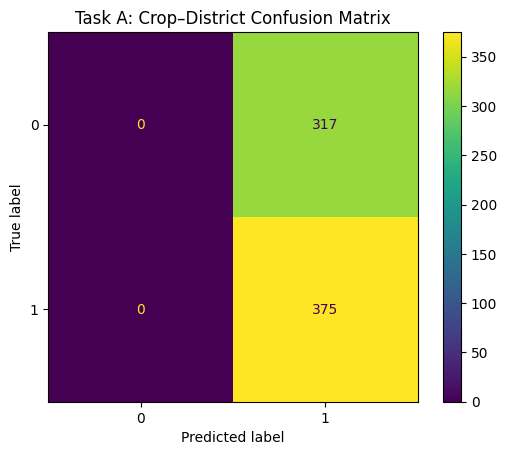

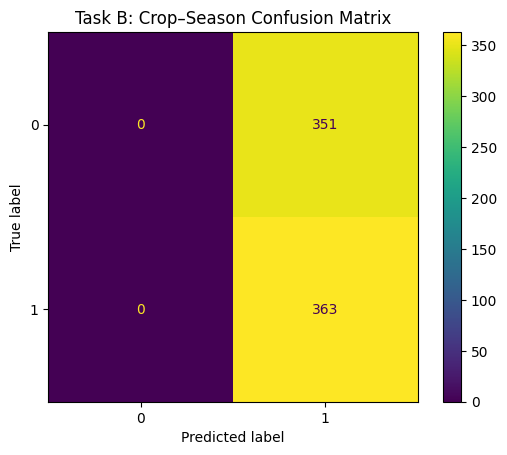

In [ ]:
model.eval()
with torch.no_grad():
    z = model(x_d, edge_index_d)

A_test_m = eval_task(z, A_te_uv_d, A_te_y_d, "A-test")
B_test_m = eval_task(z, B_te_uv_d, B_te_y_d, "B-test")

print("Task A (Crop–District)  Test:", {k:round(v,3) for k,v in A_test_m.items() if isinstance(v,(int,float))})
print("Task B (Crop–Season)    Test:", {k:round(v,3) for k,v in B_test_m.items() if isinstance(v,(int,float))})

# Confusion matrices
def show_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.title(title)
    plt.show()

show_cm(A_te_y.numpy(), A_test_m['y_pred'], "Task A: Crop–District Confusion Matrix")
show_cm(B_te_y.numpy(), B_test_m['y_pred'], "Task B: Crop–Season Confusion Matrix")


In [ ]:
from sklearn.metrics import classification_report

# Task A Report (Crop–District)
print("\nClassification Report - Task A (Crop–District):")
print(classification_report(
    A_te_y.numpy(),
    A_test_m["y_pred"],
    digits=3
))

# Task B Report (Crop–Season)
print("\nClassification Report - Task B (Crop–Season):")
print(classification_report(
    B_te_y.numpy(),
    B_test_m["y_pred"],
    digits=3
))


Classification Report - Task A (Crop–District):
              precision    recall  f1-score   support

         0.0      0.000     0.000     0.000       317
         1.0      0.542     1.000     0.703       375

    accuracy                          0.542       692
   macro avg      0.271     0.500     0.351       692
weighted avg      0.294     0.542     0.381       692


Classification Report - Task B (Crop–Season):
              precision    recall  f1-score   support

         0.0      0.000     0.000     0.000       351
         1.0      0.508     1.000     0.674       363

    accuracy                          0.508       714
   macro avg      0.254     0.500     0.337       714
weighted avg      0.258     0.508     0.343       714



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

In [ ]:
def topk_for_crop(z, crop_name, K=5):
    c_id = node2id[('crop', crop_name)]
    # Districts
    d_ids = district_ids
    uv = torch.tensor([[c_id, d] for d in d_ids], dtype=torch.long, device=device)
    with torch.no_grad():
        scores_d = torch.sigmoid(dot_decoder(z, uv)).cpu().numpy()
    top_d_idx = scores_d.argsort()[::-1][:K]
    top_d = [(districts[i], float(scores_d[i])) for i in top_d_idx]

    # Seasons
    s_ids = season_ids
    uv = torch.tensor([[c_id, s] for s in s_ids], dtype=torch.long, device=device)
    with torch.no_grad():
        scores_s = torch.sigmoid(dot_decoder(z, uv)).cpu().numpy()
    top_s_idx = scores_s.argsort()[::-1][:K]
    top_s = [(seasons[i], float(scores_s[i])) for i in top_s_idx]
    return top_d, top_s

# Example: show for first 3 crops
with torch.no_grad():
    z = model(x_d, edge_index_d)
print("Top-5 recommendations:\n")
for crop in crops[:3]:
    td, ts = topk_for_crop(z, crop, K=5)
    print(f"Crop: {crop}")
    print("  Best Districts:", td)
    print("  Best Seasons:  ", ts)
    print("-"*60)


Top-5 recommendations:

Crop: Aman
  Best Districts: [('Thakurgaon', 1.0), ('Tangail', 1.0), ('Sylhet', 1.0), ('Sunamganj', 1.0), ('Sirajganj', 1.0)]
  Best Seasons:   [('Rabi', 1.0), ('Kharif 2', 1.0), ('Kharif 1', 1.0)]
------------------------------------------------------------
Crop: Amra
  Best Districts: [('Thakurgaon', 1.0), ('Tangail', 1.0), ('Sylhet', 1.0), ('Sunamganj', 1.0), ('Sirajganj', 1.0)]
  Best Seasons:   [('Rabi', 1.0), ('Kharif 2', 1.0), ('Kharif 1', 1.0)]
------------------------------------------------------------
Crop: Arhar
  Best Districts: [('Thakurgaon', 1.0), ('Tangail', 1.0), ('Sylhet', 1.0), ('Sunamganj', 1.0), ('Sirajganj', 1.0)]
  Best Seasons:   [('Rabi', 1.0), ('Kharif 2', 1.0), ('Kharif 1', 1.0)]
------------------------------------------------------------


Knowledge Graph: 139 nodes, 4824 edges (prob ≥ 0.7)


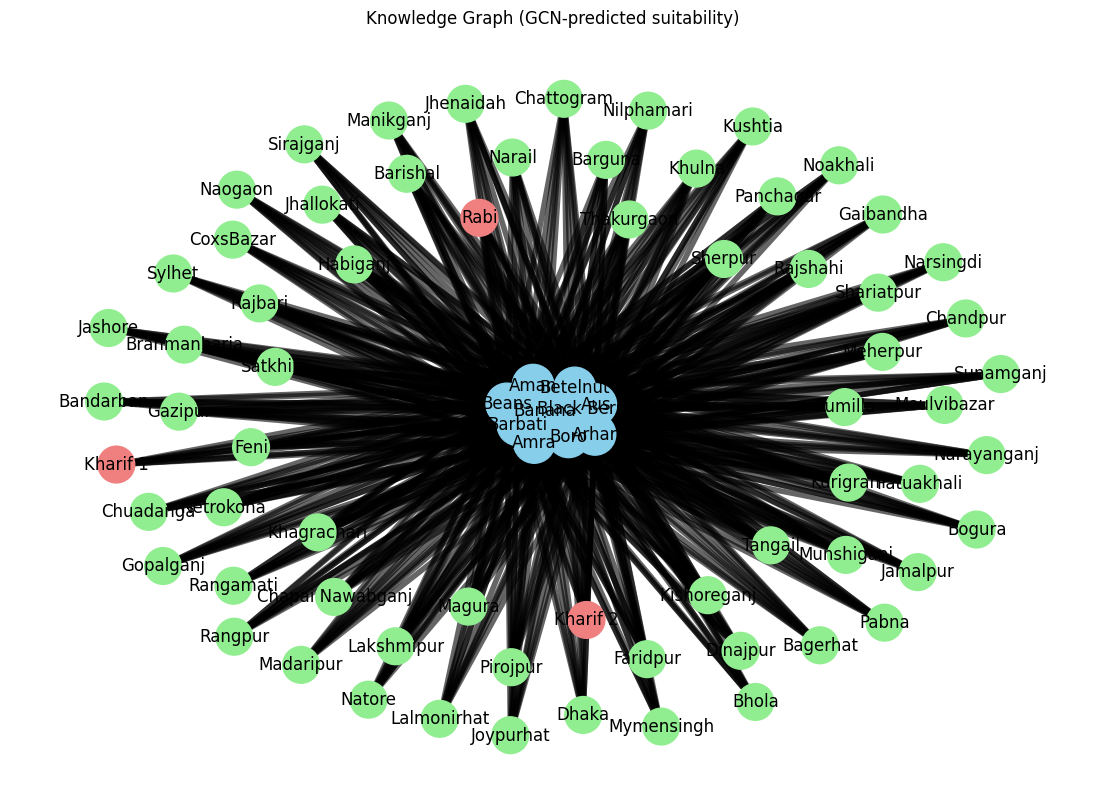

Saved KG to: /content/drive/MyDrive/Knowledge Engineering/gcn_kg.graphml


In [ ]:
# Threshold for KG edges
TH = 0.7

KG = nx.Graph()
# Add nodes with type labels
for c in crops:    KG.add_node(('crop', c),    type='crop')
for d in districts:KG.add_node(('district', d),type='district')
for s in seasons:  KG.add_node(('season', s),  type='season')

# Add high-probability predicted links (Crop–District and Crop–Season)
with torch.no_grad():
    z = model(x_d, edge_index_d)

# Crop–District predicted edges
for ci, c in enumerate(crops):
    c_id = node2id[('crop', c)]
    uv = torch.tensor([[c_id, d] for d in district_ids], dtype=torch.long, device=device)
    p = torch.sigmoid(dot_decoder(z, uv)).cpu().numpy()
    for j, d_id in enumerate(district_ids):
        if p[j] >= TH:
            d_name = districts[j]
            KG.add_edge(('crop', c), ('district', d_name), prob=float(p[j]), relation='suitable')

# Crop–Season predicted edges
for ci, c in enumerate(crops):
    c_id = node2id[('crop', c)]
    uv = torch.tensor([[c_id, s] for s in season_ids], dtype=torch.long, device=device)
    p = torch.sigmoid(dot_decoder(z, uv)).cpu().numpy()
    for j, s_id in enumerate(season_ids):
        if p[j] >= TH:
            s_name = seasons[j]
            KG.add_edge(('crop', c), ('season', s_name), prob=float(p[j]), relation='best_season')

print(f"Knowledge Graph: {KG.number_of_nodes()} nodes, {KG.number_of_edges()} edges (prob ≥ {TH})")

# --- Visualize KG (small subset for readability) ---
plt.figure(figsize=(14,10))
# Take a subgraph: top 10 crops by degree in KG to keep plot readable
crop_degrees = [(n, KG.degree[n]) for n in KG.nodes if isinstance(n, tuple) and n[0]=='crop']
crop_degrees = sorted(crop_degrees, key=lambda x: x[1], reverse=True)[:10]
keep_nodes = set(n for n,_ in crop_degrees)
for c in keep_nodes.copy():
    keep_nodes |= set(KG.neighbors(c))
SG = KG.subgraph(keep_nodes).copy()

pos = nx.spring_layout(SG, seed=42)
colors = []
sizes = []
for n, data in SG.nodes(data=True):
    if data['type']=='crop':
        colors.append('skyblue'); sizes.append(900)
    elif data['type']=='district':
        colors.append('lightgreen'); sizes.append(700)
    else:
        colors.append('lightcoral'); sizes.append(700)

nx.draw_networkx_nodes(SG, pos, node_color=colors, node_size=sizes)
nx.draw_networkx_labels(SG, pos, labels={n: n[1] for n in SG.nodes()})

# Edge width by probability
widths = [1 + 3*SG.edges[e].get('prob',0.5) for e in SG.edges()]
nx.draw_networkx_edges(SG, pos, width=widths, alpha=0.6)
plt.title("Knowledge Graph (GCN-predicted suitability)")
plt.axis('off')
plt.show()

# (Optional) Export full KG to GraphML for Gephi/Neo4j Desktop etc.
nx.write_graphml(KG, "/content/drive/MyDrive/Knowledge Engineering/gcn_kg.graphml")
print("Saved KG to: /content/drive/MyDrive/Knowledge Engineering/gcn_kg.graphml")


#2nd approach

In [ ]:
!pip -q install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip -q install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.4.0+cu121.html
!pip -q install scikit-learn matplotlib networkx pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 95.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 100.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 88.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.6/989.6 kB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
import torch
from torch_geometric.data import Data

In [ ]:
# --- Mount & Load ---
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv("/content/drive/MyDrive/Knowledge Engineering/Dataset/SPAS-Dataset-BD.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# --- Basic cleaning / columns ---
df.columns=["Area","AP_Ratio","District","Season","Avg_Temp","Avg_Humidity","Crop_Name",
            "Transplant","Growth","Harvest","Production","Max_Temp","Min_Temp",
            "Max_Relative_Humidity","Min_Relative_Humidity"]
df['Crop_Name'] = df['Crop_Name'].replace('#REF!', 'Taramind')
df['AP_Ratio'] = pd.to_numeric(df['AP_Ratio'], errors='coerce')
df['AP_Ratio'] = df['AP_Ratio'].replace(' #DIV/0!',df['AP_Ratio'].mean())
print(df.dtypes)


Area                       int64
AP_Ratio                 float64
District                  object
Season                    object
Avg_Temp                 float64
Avg_Humidity             float64
Crop_Name                 object
Transplant                object
Growth                    object
Harvest                   object
Production                 int64
Max_Temp                   int64
Min_Temp                 float64
Max_Relative_Humidity      int64
Min_Relative_Humidity      int64
dtype: object


In [ ]:
df.isnull().sum()

,0
Area,0
AP_Ratio,416
District,0
Season,1
Avg_Temp,0
Avg_Humidity,0
Crop_Name,0
Transplant,0
Growth,0
Harvest,0


In [ ]:
df.ffill(inplace=True)

In [ ]:
df.isnull().sum()

,0
Area,0
AP_Ratio,0
District,0
Season,0
Avg_Temp,0
Avg_Humidity,0
Crop_Name,0
Transplant,0
Growth,0
Harvest,0


In [ ]:
# Encode categorical columns
le_crop = LabelEncoder()
df["Crop_ID"] = le_crop.fit_transform(df["Crop_Name"])

le_season = LabelEncoder()
df["Season_ID"] = le_season.fit_transform(df["Season"])

# Select numeric features for clustering
features = ["AP_Ratio", "Avg_Temp", "Avg_Humidity"]
X = df[features].values

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Run KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df["Cluster"] = kmeans.fit_predict(X_scaled)

print(df[["Crop_Name", "Season", "Cluster"]].head())

  Crop_Name    Season  Cluster
0      Aman  Kharif 2        0
1      Aman  Kharif 2        0
2      Aman  Kharif 2        0
3      Aman  Kharif 2        0
4      Aman  Kharif 2        0


In [ ]:
#
import networkx as nx

G = nx.Graph()

# Add nodes
for i, row in df.iterrows():
    G.add_node(row["Crop_ID"], type="crop")
    G.add_node(row["Season_ID"] + 1000, type="season")   # offset to avoid overlap
    G.add_node(row["Cluster"] + 2000, type="cluster")   # offset again

    # Edges
    G.add_edge(row["Crop_ID"], row["Season_ID"] + 1000)
    G.add_edge(row["Crop_ID"], row["Cluster"] + 2000)

# Convert to torch-geometric format
node_mapping = {n:i for i,n in enumerate(G.nodes())}
edge_index = torch.tensor([[node_mapping[u], node_mapping[v]] for u,v in G.edges()], dtype=torch.long).t().contiguous()

# Node features (just use cluster as feature for simplicity)
x = torch.eye(len(G.nodes()))

# Labels: season prediction
y = torch.zeros(len(G.nodes()), dtype=torch.long)
for i, row in df.iterrows():
    crop_node = node_mapping[row["Crop_ID"]]
    y[crop_node] = row["Season_ID"]

data = Data(x=x, edge_index=edge_index, y=y)

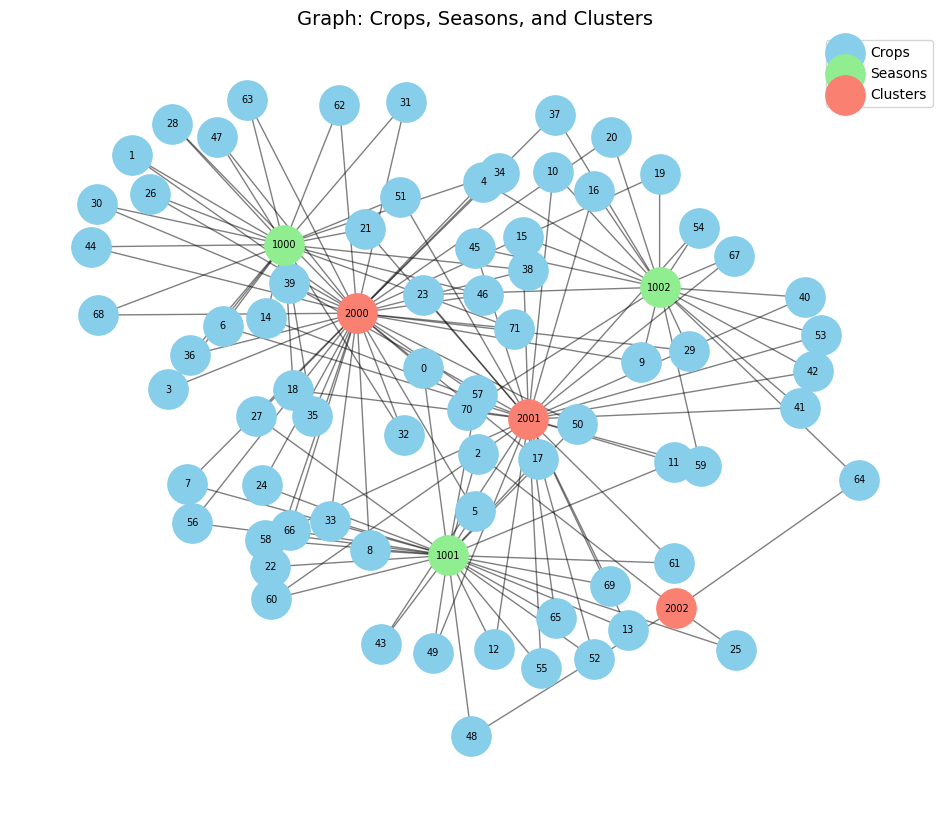

In [ ]:
import matplotlib.pyplot as plt

# --- Separate nodes by type ---
crop_nodes    = [n for n, d in G.nodes(data=True) if d["type"] == "crop"]
season_nodes  = [n for n, d in G.nodes(data=True) if d["type"] == "season"]
cluster_nodes = [n for n, d in G.nodes(data=True) if d["type"] == "cluster"]

# --- Assign colors ---
color_map = []
for n in G.nodes():
    if n in crop_nodes:
        color_map.append("skyblue")
    elif n in season_nodes:
        color_map.append("lightgreen")
    elif n in cluster_nodes:
        color_map.append("salmon")

# --- Layout (spring_layout looks better for connected graphs) ---
pos = nx.spring_layout(G, k=0.5, seed=42)  # k controls spacing

plt.figure(figsize=(12, 10))

# Draw nodes with colors
nx.draw_networkx_nodes(G, pos, nodelist=crop_nodes,    node_color="skyblue", node_size=800, label="Crops")
nx.draw_networkx_nodes(G, pos, nodelist=season_nodes,  node_color="lightgreen", node_size=800, label="Seasons")
nx.draw_networkx_nodes(G, pos, nodelist=cluster_nodes, node_color="salmon", node_size=800, label="Clusters")

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.5)

# Draw labels (use IDs for now)
nx.draw_networkx_labels(G, pos, font_size=7)

plt.title("Graph: Crops, Seasons, and Clusters", fontsize=14)
plt.axis("off")
plt.legend(scatterpoints=1, fontsize=10)
plt.show()

In [ ]:
#Build GNN Model
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GNN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [ ]:
#Train GNN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GNN(data.num_node_features, 16, len(df["Season_ID"].unique())).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
data = data.to(device)

# Train loop
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)

    # Only crops have labels
    mask = (data.y > 0)
    loss = F.cross_entropy(out[mask], data.y[mask])
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        pred = out.argmax(dim=1)
        acc = (pred[mask] == data.y[mask]).sum().item() / mask.sum().item()
        print(f"Epoch {epoch}, Loss {loss.item():.4f}, Acc {acc:.4f}")


Epoch 0, Loss 1.1228, Acc 0.0208
Epoch 20, Loss 0.3856, Acc 0.9792
Epoch 40, Loss 0.0615, Acc 1.0000
Epoch 60, Loss 0.0167, Acc 1.0000
Epoch 80, Loss 0.0096, Acc 1.0000


              precision    recall  f1-score   support

    Kharif 1       0.00      0.00      0.00         0
    Kharif 2       1.00      1.00      1.00        28
        Rabi       1.00      1.00      1.00        20

    accuracy                           1.00        48
   macro avg       0.67      0.67      0.67        48
weighted avg       1.00      1.00      1.00        48



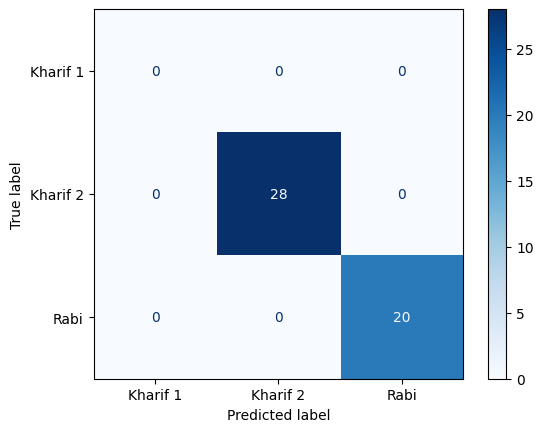

In [ ]:
#Evaluate
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model.eval()
out = model(data.x, data.edge_index)
pred = out.argmax(dim=1).cpu().numpy()
true = data.y.cpu().numpy()

# Only crops
mask = (true > 0)
print(classification_report(
    true[mask],
    pred[mask],
    labels=np.arange(len(le_season.classes_)),   # force all encoded labels [0,1,2,...]
    target_names=le_season.classes_,
    zero_division=0
))
cm = confusion_matrix(true[mask], pred[mask], labels=np.arange(len(le_season.classes_)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le_season.classes_)
disp.plot(cmap="Blues")
plt.show()

Epoch 0, Loss 0.0071, Acc 1.0000
Epoch 20, Loss 0.0056, Acc 1.0000
Epoch 40, Loss 0.0046, Acc 1.0000
Epoch 60, Loss 0.0039, Acc 1.0000
Epoch 80, Loss 0.0033, Acc 1.0000


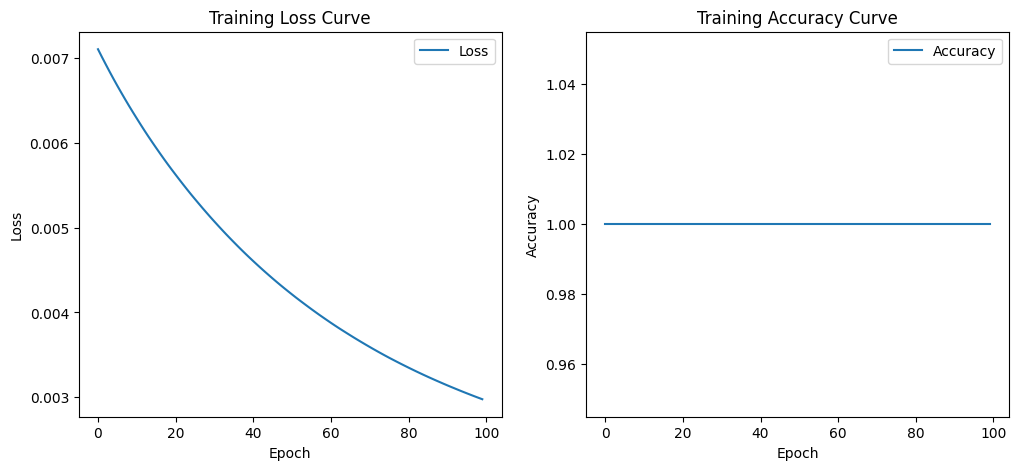

In [ ]:
train_losses = []
train_accs = []

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)

    # Only crops have labels
    mask = (data.y > 0)
    loss = F.cross_entropy(out[mask], data.y[mask])
    loss.backward()
    optimizer.step()

    # Track loss & acc
    pred = out.argmax(dim=1)
    acc = (pred[mask] == data.y[mask]).sum().item() / mask.sum().item()

    train_losses.append(loss.item())
    train_accs.append(acc)

    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss {loss.item():.4f}, Acc {acc:.4f}")

# Plot loss & accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label="Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Curve")
plt.legend()

plt.show()

#3rd Approach

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
import torch
from torch_geometric.data import Data

In [ ]:
# --- Mount & Load ---
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv("/content/drive/MyDrive/Knowledge Engineering/Dataset/SPAS-Dataset-BD.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# --- Basic cleaning / columns ---
df.columns=["Area","AP_Ratio","District","Season","Avg_Temp","Avg_Humidity","Crop_Name",
            "Transplant","Growth","Harvest","Production","Max_Temp","Min_Temp",
            "Max_Relative_Humidity","Min_Relative_Humidity"]
df['Crop_Name'] = df['Crop_Name'].replace('#REF!', 'Taramind')
df['AP_Ratio'] = pd.to_numeric(df['AP_Ratio'], errors='coerce')
df['AP_Ratio'] = df['AP_Ratio'].replace(' #DIV/0!',df['AP_Ratio'].mean())
print(df.dtypes)


Area                       int64
AP_Ratio                 float64
District                  object
Season                    object
Avg_Temp                 float64
Avg_Humidity             float64
Crop_Name                 object
Transplant                object
Growth                    object
Harvest                   object
Production                 int64
Max_Temp                   int64
Min_Temp                 float64
Max_Relative_Humidity      int64
Min_Relative_Humidity      int64
dtype: object


In [ ]:
df.isnull().sum()

,0
Area,0
AP_Ratio,416
District,0
Season,1
Avg_Temp,0
Avg_Humidity,0
Crop_Name,0
Transplant,0
Growth,0
Harvest,0


In [ ]:
df.ffill(inplace=True)

In [ ]:
df.isnull().sum()

,0
Area,0
AP_Ratio,0
District,0
Season,0
Avg_Temp,0
Avg_Humidity,0
Crop_Name,0
Transplant,0
Growth,0
Harvest,0


In [ ]:
# Encode categorical columns
le_crop = LabelEncoder()
df["Crop_ID"] = le_crop.fit_transform(df["Crop_Name"])

le_season = LabelEncoder()
df["Season_ID"] = le_season.fit_transform(df["Season"])

# Select numeric features for clustering
features = ["AP_Ratio", "Avg_Temp", "Avg_Humidity"]
X = df[features].values

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Run KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df["Cluster"] = kmeans.fit_predict(X_scaled)

print(df[["Crop_Name", "Season", "Cluster"]].head())

  Crop_Name    Season  Cluster
0      Aman  Kharif 2        0
1      Aman  Kharif 2        0
2      Aman  Kharif 2        0
3      Aman  Kharif 2        0
4      Aman  Kharif 2        0


In [ ]:
#Create Graph for GNN
import networkx as nx
G = nx.Graph()
edges = []
weights = []
 # Select best season per crop (multi-class)
best_season = df.groupby("Crop_ID")["Production"].idxmax()
df_best = df.loc[best_season]
for i, row in df.iterrows():
  u = row["Crop_ID"]
  v_season = row["Season_ID"] + 1000
  v_cluster = row["Cluster"] + 2000 # Add nodes
  G.add_node(u, type="crop")
  G.add_node(v_season, type="season")
  G.add_node(v_cluster, type="cluster")
  # Add weighted edges
  G.add_edge(u, v_season, weight=row["Production"])
  G.add_edge(u, v_cluster, weight=1.0)

# Node mapping
node_mapping = {n: i for i, n in enumerate(G.nodes())}
num_nodes = len(G.nodes())

# Edge index & weight
edge_index = torch.tensor([[node_mapping[u], node_mapping[v]] for u, v in G.edges()], dtype=torch.long).t().contiguous()
edge_weight = torch.tensor([G[u][v]["weight"] for u, v in G.edges()], dtype=torch.float)

# ---------------------------------
# 2. Node Features
# ---------------------------------
scaler = StandardScaler()
crop_features = df_best[["AP_Ratio", "Avg_Temp", "Avg_Humidity"]].values
crop_features = scaler.fit_transform(crop_features)
x = np.zeros((num_nodes, crop_features.shape[1]))
for idx, row in enumerate(df_best.itertuples()):
    crop_node = node_mapping[row.Crop_ID]
    x[crop_node] = crop_features[idx]

x = torch.tensor(x, dtype=torch.float)

# ---------------------------------
# 3. Labels (multi-class: one best season per crop)
# ---------------------------------
y = torch.zeros(num_nodes, dtype=torch.long)
for i, row in df_best.iterrows():
  crop_node = node_mapping[row["Crop_ID"]]
  y[crop_node] = row["Season_ID"] # best season only

# Mask (only crops have labels)
mask = torch.zeros(num_nodes, dtype=torch.bool)
for crop in df_best["Crop_ID"]:
  mask[node_mapping[crop]] = True
data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight, y=y)

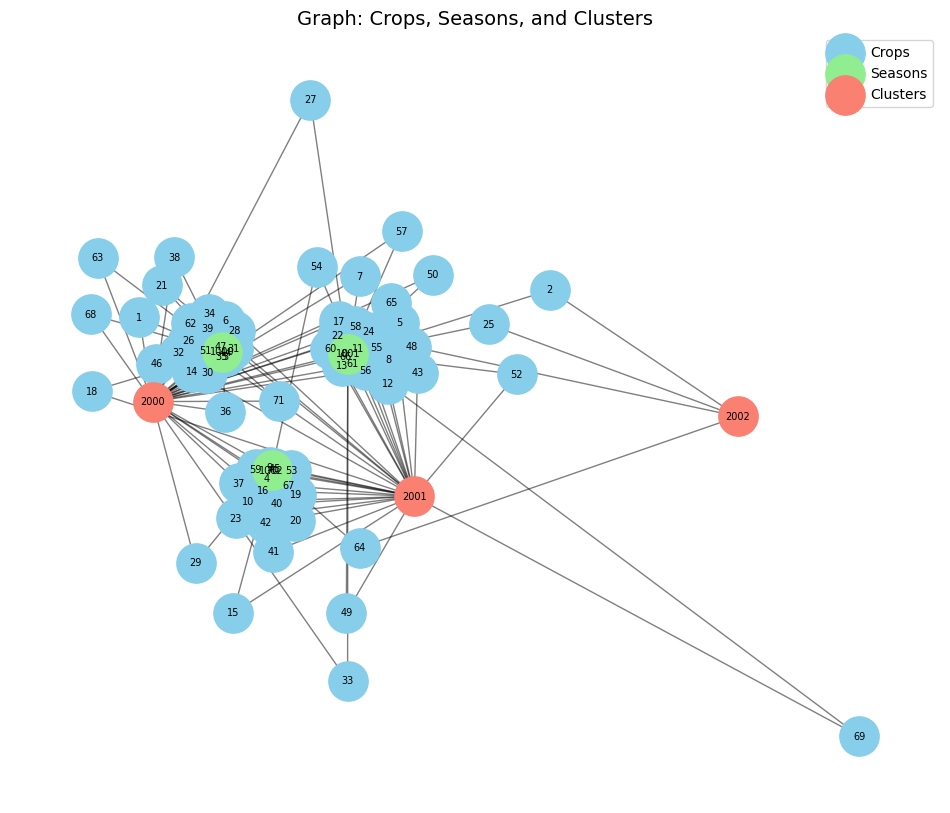

In [ ]:
import matplotlib.pyplot as plt

# --- Separate nodes by type ---
crop_nodes    = [n for n, d in G.nodes(data=True) if d["type"] == "crop"]
season_nodes  = [n for n, d in G.nodes(data=True) if d["type"] == "season"]
cluster_nodes = [n for n, d in G.nodes(data=True) if d["type"] == "cluster"]

# --- Assign colors ---
color_map = []
for n in G.nodes():
    if n in crop_nodes:
        color_map.append("skyblue")
    elif n in season_nodes:
        color_map.append("lightgreen")
    elif n in cluster_nodes:
        color_map.append("salmon")

# --- Layout (spring_layout looks better for connected graphs) ---
pos = nx.spring_layout(G, k=0.5, seed=42)  # k controls spacing

plt.figure(figsize=(12, 10))

# Draw nodes with colors
nx.draw_networkx_nodes(G, pos, nodelist=crop_nodes,    node_color="skyblue", node_size=800, label="Crops")
nx.draw_networkx_nodes(G, pos, nodelist=season_nodes,  node_color="lightgreen", node_size=800, label="Seasons")
nx.draw_networkx_nodes(G, pos, nodelist=cluster_nodes, node_color="salmon", node_size=800, label="Clusters")

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.5)

# Draw labels (use IDs for now)
nx.draw_networkx_labels(G, pos, font_size=7)

plt.title("Graph: Crops, Seasons, and Clusters", fontsize=14)
plt.axis("off")
plt.legend(scatterpoints=1, fontsize=10)
plt.show()

In [ ]:
# ---------------------------------
# 4. GNN Model
# ---------------------------------
class GNN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_dim)

    def forward(self, x, edge_index, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight=edge_weight)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_weight=edge_weight)
        return x


In [ ]:
# ---------------------------------
# 5. Training
# ---------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GNN(data.num_node_features, 16, len(df["Season_ID"].unique())).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

data = data.to(device)
mask = mask.to(device)

losses, accs = [], []

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_weight)
    loss = F.cross_entropy(out[mask], data.y[mask])
    loss.backward()
    optimizer.step()

    # Track performance
    pred = out.argmax(dim=1)
    acc = (pred[mask] == data.y[mask]).sum().item() / mask.sum().item()
    losses.append(loss.item())
    accs.append(acc)

    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss {loss.item():.4f}, Acc {acc:.4f}")


Epoch 0, Loss 8.6332, Acc 0.2917
Epoch 20, Loss 0.3418, Acc 0.9583
Epoch 40, Loss 0.2184, Acc 0.9722
Epoch 60, Loss 0.1861, Acc 0.9722
Epoch 80, Loss 0.1641, Acc 0.9722



Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        24
           1       0.93      1.00      0.97        28
           2       1.00      0.95      0.97        20

    accuracy                           0.97        72
   macro avg       0.98      0.97      0.97        72
weighted avg       0.97      0.97      0.97        72



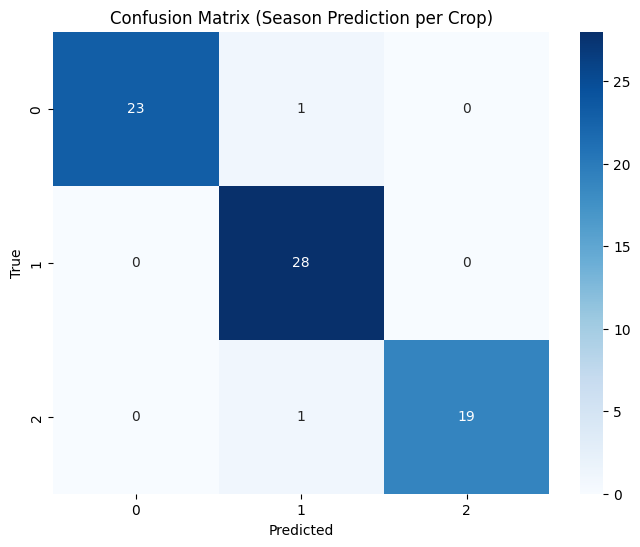

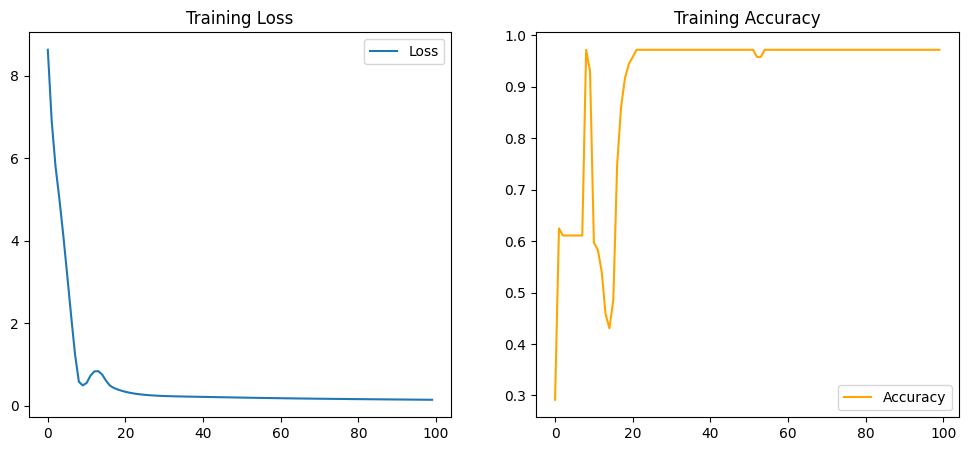

In [ ]:
# ---------------------------------
# 6. Evaluation
# ---------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

model.eval()
out = model(data.x, data.edge_index, data.edge_weight)
pred = out.argmax(dim=1).cpu().numpy()
true = data.y.cpu().numpy()

print("\nClassification Report:")
print(classification_report(true[mask.cpu()], pred[mask.cpu()]))

cm = confusion_matrix(true[mask.cpu()], pred[mask.cpu()])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Season Prediction per Crop)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Plot loss & accuracy curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(losses, label="Loss")
plt.legend(); plt.title("Training Loss")

plt.subplot(1,2,2)
plt.plot(accs, label="Accuracy", color="orange")
plt.legend(); plt.title("Training Accuracy")
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

# Get crop node indices
crop_nodes = [node_mapping[c] for c in df_best["Crop_ID"]]

train_idx, test_idx = train_test_split(crop_nodes, test_size=0.2, random_state=42)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[train_idx] = True
test_mask[test_idx] = True

In [ ]:
# ---------------------------------
# 4. GNN Model
# ---------------------------------
class GNN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_dim)

    def forward(self, x, edge_index, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight=edge_weight)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_weight=edge_weight)
        return x

In [ ]:
# ---------------------------------
# 5. Training
# ---------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GNN(data.num_node_features, 16, len(df["Season_ID"].unique())).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

data = data.to(device)
mask = mask.to(device)

losses, accs = [], []

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_weight)
    loss = F.cross_entropy(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    # Track train acc
    pred = out.argmax(dim=1)
    acc = (pred[train_mask] == data.y[train_mask]).sum().item() / train_mask.sum().item()

    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss {loss.item():.4f}, Train Acc {acc:.4f}")

Epoch 0, Loss 8.0280, Train Acc 0.2807
Epoch 20, Loss 0.2515, Train Acc 0.9825
Epoch 40, Loss 0.1483, Train Acc 1.0000
Epoch 60, Loss 0.1202, Train Acc 1.0000
Epoch 80, Loss 0.0944, Train Acc 1.0000



Classification Report (Test Crops):
              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       0.75      0.75      0.75         4
           2       1.00      0.80      0.89         5

    accuracy                           0.87        15
   macro avg       0.87      0.85      0.85        15
weighted avg       0.88      0.87      0.87        15



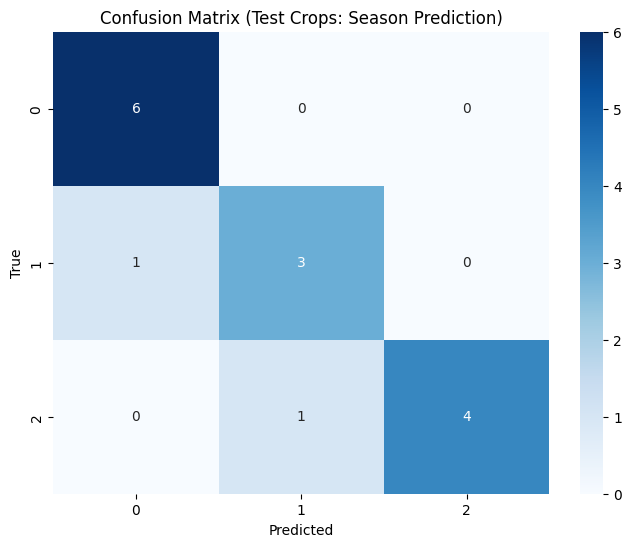

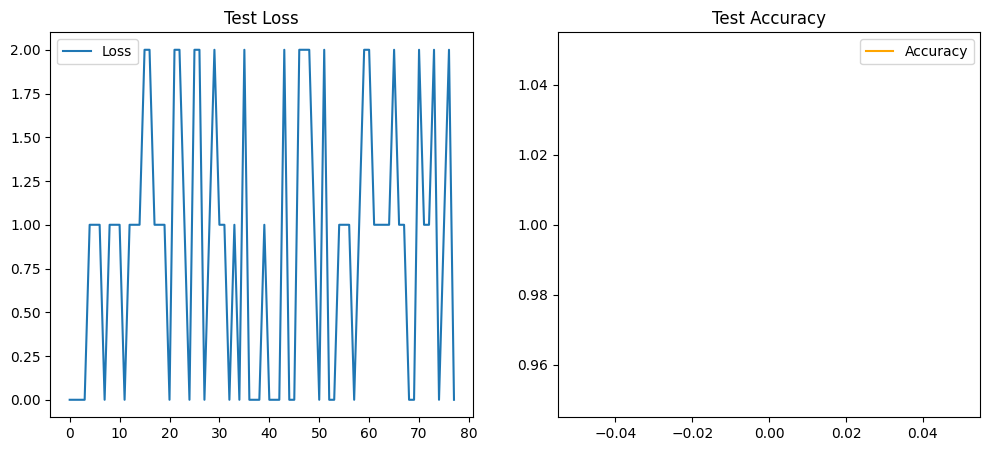

In [ ]:
model.eval()
out = model(data.x, data.edge_index, data.edge_weight)
pred = out.argmax(dim=1).cpu().numpy()
true = data.y.cpu().numpy()

# Only crops in test set
print("\nClassification Report (Test Crops):")
print(classification_report(true[test_mask.cpu()], pred[test_mask.cpu()]))

cm = confusion_matrix(true[test_mask.cpu()], pred[test_mask.cpu()])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Test Crops: Season Prediction)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Plot loss & accuracy curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(pred, label="Loss")
plt.legend(); plt.title("Test Loss")

plt.subplot(1,2,2)
plt.plot(acc, label="Accuracy", color="orange")
plt.legend(); plt.title("Test Accuracy")
plt.show()

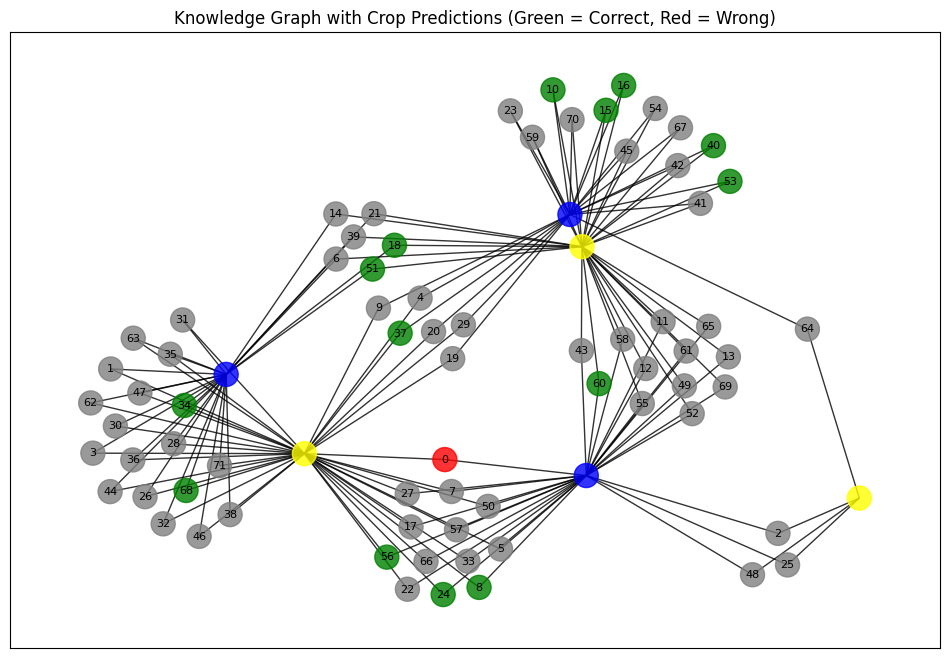

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Build graph again (or reuse if already stored)
G = nx.Graph()
for i, row in df_best.iterrows():
    crop_node = row["Crop_ID"]
    season_node = row["Season_ID"] + 1000
    cluster_node = row["Cluster"] + 2000

    G.add_node(crop_node, type="crop")
    G.add_node(season_node, type="season")
    G.add_node(cluster_node, type="cluster")

    G.add_edge(crop_node, season_node)
    G.add_edge(crop_node, cluster_node)

# Get predictions
model.eval()
out = model(data.x, data.edge_index, data.edge_weight)
pred = out.argmax(dim=1).cpu().numpy()
true = data.y.cpu().numpy()

# Assign colors:
#   ✅ green = correct prediction
#   ❌ red   = wrong prediction
#   🔵 blue  = season nodes
#   🟡 yellow= cluster nodes
node_colors = []
for n in G.nodes():
    node_type = G.nodes[n].get("type")
    if node_type == "crop":
        if n in test_idx:  # only color test crops
            if pred[node_mapping[n]] == true[node_mapping[n]]:
                node_colors.append("green")  # correct
            else:
                node_colors.append("red")    # wrong
        else:
            node_colors.append("gray")  # training crops
    elif node_type == "season":
        node_colors.append("blue")
    elif node_type == "cluster":
        node_colors.append("yellow")
    else:
        node_colors.append("black")

# Layout
pos = nx.spring_layout(G, seed=42)

# Draw
plt.figure(figsize=(12, 8))
nx.draw_networkx(
    G, pos,
    node_color=node_colors,
    with_labels=False,
    node_size=300,
    alpha=0.8
)

# Add labels for crops only
crop_labels = {n: n for n in G.nodes() if G.nodes[n].get("type") == "crop"}
nx.draw_networkx_labels(G, pos, labels=crop_labels, font_size=8, font_color="black")

plt.title("Knowledge Graph with Crop Predictions (Green = Correct, Red = Wrong)")
plt.show()